#ResNet50 y módulos de atención

**Integrantes**


*   Andrea Franco
*   Andres Varela
*   Carlos Urbano
*   Hardy Galvis



In [ ]:
import tensorflow as tf
import sklearn
import scipy
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Add
from tensorflow.keras.layers import GlobalAveragePooling2D, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.initializers import glorot_uniform
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
from keras import Model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.models import load_model

In [ ]:
import tensorflow as tf

# Verifica la disponibilidad de GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configura para que TensorFlow use toda la memoria GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        # Puedes también especificar qué GPU quieres usar, si tienes varias
            tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        print("GPUs disponibles:", len(gpus))
    except RuntimeError as e:
        print(e)

# Ahora puedes construir y ejecutar tu modelo de TensorFlow aquí


GPUs disponibles: 1


Cargando el Dataset desde ruta

In [ ]:
# Cargando el dataset

train_path = "G:/tenis/augmented2/train"

test_path = "G:/tenis/augmented2/test"

Utilizamos el prepocess input de Keras que nos deja listas las imagenes para trabajar con la ResNet de Keras.
Luego preparamos losobjetos Image.Datagenerator para realizar data augmentation de las imagenes, modificando parametros como rotacion, ancho , alto y dividimos el set de entrenamiento en un 20% para validacion

In [ ]:

from keras.applications.resnet_v2 import preprocess_input
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(dtype='float32',preprocessing_function=preprocess_input, featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(dtype='float32',preprocessing_function=preprocess_input)

se realiza la lectura desde la biblioteca apar asignar cada set a su respectivo generador

In [ ]:


training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 16,

                                                 class_mode = 'sparse',
                                                 subset="training")


valid_set = train_datagen.flow_from_directory(train_path,
                                            target_size = (224, 224),
                                            batch_size = 16,

                                            class_mode = 'sparse',
                                            subset="validation")

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 16,
                                            class_mode = 'sparse')



Found 3833 images belonging to 3 classes.
Found 956 images belonging to 3 classes.
Found 1935 images belonging to 3 classes.


Se obtienen los labels del set de entranmiento y de testeo para previa validacion

In [ ]:
train_y = training_set.classes
test_y = test_set.classes

## Transfer Learning ResNet50V2 Keras

Utilizando la aplicacion de la Resnet50V2 de Keras, definimos un modelo base para realizar el entrenamiento de las imagenes. La ventaja de utilizar esta aplicacion radica en la utilizacion de pesos de imagenet.

In [ ]:
base_model=keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling=max,
    classes=3,
    classifier_activation="softmax",
)

Anadimos a nuestro modelo base las capas necesarias para ajustarlas a nuestro ejercicio especifico.
El proposito de esta red consiste en clasificar imagenes en 3 categorias, por eso agregamos en la capa final una desna con 3 neuronas.

In [ ]:
#base_model = tf.keras.applications.ResNet50V2(include_top = False,input_shape=(224, 224, 3),)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape = (224, 224, 3), name = 'InputLayer')
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D(name = 'global_average_pooling_layer')(x)
x = Flatten()(x)
x = tf.keras.layers.Dense(512, activation = 'softmax', name = 'Dense_layer')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(3, activation = 'softmax', name = 'output_layer')(x)


model = tf.keras.Model(inputs, outputs)

Analizando la arquitectura del BaseModel se puede enteder la distribucion entre capas para posteriormente incluir los modulos de atencion.

In [ ]:
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_33[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

Al compilar el modelo utilizamos Adam como optimizador y sparse_categorical_crossentropy para clasificar nuestros labels en numeros del 0-2

*  0:Adidas
*  1:Converse
*  2:Nike

Utilizando TopKCategoricalAcurracy obtenemos el accuracy del numero de categorias que definimos, para este caso k=1, es el indicador opuesto al Top1Error

In [ ]:
from tensorflow.keras.metrics import TopKCategoricalAccuracy
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics = ['accuracy',TopKCategoricalAccuracy(k=1)]
)

guardamos el modelo para analizar posteriormente la arquitectura

In [ ]:
base_model.save('resnet50v2.h5')


Entrenando la Red:

In [ ]:
hist = model.fit(training_set,
                validation_data = valid_set,
                epochs = 20,
                steps_per_epoch=len(training_set),
                validation_steps=len(valid_set))

c:\Users\AndresVJ\.conda\envs\tf\lib\site-packages\keras\preprocessing\image.py:1863: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
c:\Users\AndresVJ\.conda\envs\tf\lib\site-packages\keras\preprocessing\image.py:1873: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/20
240/240 [==============================] - 94s 355ms/step - loss: 1.0026 - accuracy: 0.5881 - top_k_categorical_accuracy: 0.4143 - val_loss: 0.9344 - val_accuracy: 0.6810 - val_top_k_categorical_accuracy: 0.2845
Epoch 2/20
240/240 [==============================] - 55s 228ms/step - loss: 0.8516 - accuracy: 0.6799 - top_k_categorical_accuracy: 0.2992 - val_loss: 0.8412 - val_accuracy: 0.7071 - val_top_k_categorical_accuracy: 0.2228
Epoch 3/20
240/240 [==============================] - 58s 240ms/step - loss: 0.7490 - accuracy: 0.7172 - top_k_categorical_accuracy: 0.2992 - val_loss: 0.7824 - val_accuracy: 0.7144 - val_top_k_categorical_accuracy: 0.2354
Epoch 4/20
240/240 [==============================] - 56s 233ms/step - loss: 0.6806 - accuracy: 0.7263 - top_k_categorical_accuracy: 0.3032 - val_loss: 0.7347 - val_accuracy: 0.7291 - val_top_k_categorical_accuracy: 0.3347
Epoch 5/20
240/240 [==============================] - 58s 240ms/step - loss: 0.6258 - accuracy: 0.7323 - top

In [ ]:
# Evaluate the model
loss, acc, top1_acc = model.evaluate(test_set, verbose=0)

print(f'Top-1 Accuracy: {top1_acc * 100:.2f}%')

Top-1 Accuracy: 28.53%


In [ ]:
model.save('resnet50.h5')
model.save_weights('resnet50_weights.h5')

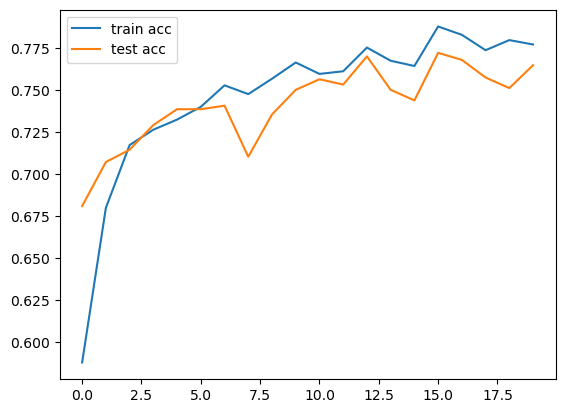

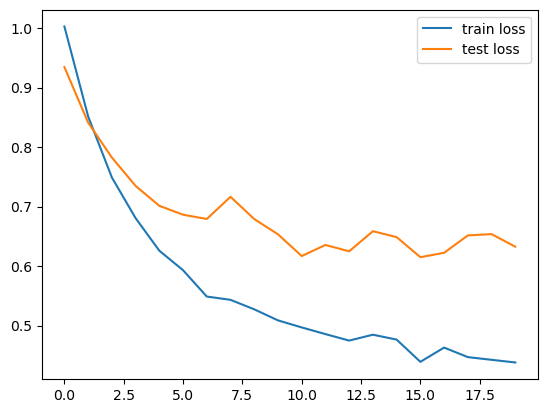

In [ ]:
plt.plot(hist.history['accuracy'], label='train acc')

plt.plot(hist.history['val_accuracy'], label='test acc')

plt.legend()

plt.savefig('resnet50-acc-rps-1.png')

plt.show()

# loss
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='test loss')
plt.legend()
plt.savefig('resnet50-loss-rps-1.png')
plt.show()

Calculando Matriz de confusion

In [ ]:
#predict
y_pred = model.predict(test_set)
y_pred = np.argmax(y_pred,axis=1)

#get classification report
print(classification_report(y_pred,test_y))

#get confusion matrix
cm = confusion_matrix(y_pred,test_y)

print(cm)

121/121 [==============================] - 5s 33ms/step
              precision    recall  f1-score   support

           0       0.28      0.32      0.30       552
           1       0.39      0.34      0.36       738
           2       0.33      0.33      0.33       645

    accuracy                           0.33      1935
   macro avg       0.33      0.33      0.33      1935
weighted avg       0.34      0.33      0.33      1935

[[179 178 195]
 [255 248 235]
 [212 217 216]]


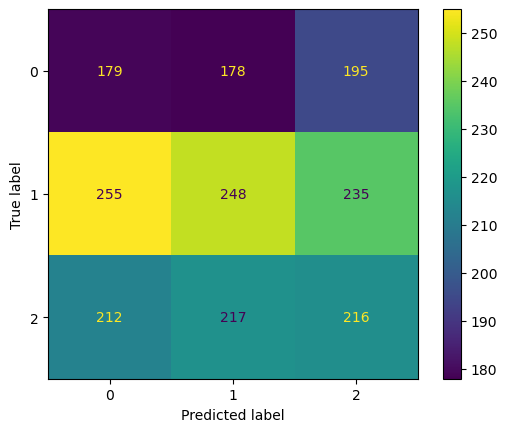

In [ ]:
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

## GRADCAM

para hacer uso del Gradcam primero cargamamos una imagen del dataset de test y verificamos su prediccion.

In [ ]:
imagen="/content/drive/MyDrive/especializacion/DL_Avanzado/final/augmented2/test/converse/dr_9_6078.jpg"
img_arr=cv2.imread(imagen,cv2.IMREAD_COLOR)
img_arr=cv2.resize(img_arr,(224,224))


pred_cam = model.predict(img_arr.reshape(1,224,224,3))

print(np.argmax(pred_cam[0]))

1/1 [==============================] - 1s 864ms/step
2


utilizando el summary de keras definimos cual es la ultima capa convolucional del modelo, al haber realizado transfer learning de nuestro modelo SENET, y como dicho modelo no incorpora las capas de clasificacion, lo tomamos como nuestra ultima capa convolucional denominada "model_40" es importante tener en cuenta que esta capa no recibe un nombre especifico y cada vez que la ejecutemos va a cambiar su nomenclatura.

In [ ]:
model.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling_lay  (None, 2048)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 Dense_layer (Dense)         (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0  

In [ ]:
last_conv_layer = base_model.get_layer('conv5_block3_out')
last_conv_layer

In [ ]:
last_conv_layer = base_model.get_layer('conv5_block3_out')

last_conv_layer_model = tf.keras.Model(base_model.inputs, last_conv_layer.output)

classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
x = model.get_layer('global_average_pooling_layer')(x)
x = model.get_layer('Dense_layer')(x)
x = model.get_layer('output_layer')(x)
classifier_model = tf.keras.Model(classifier_input, x)



with tf.GradientTape() as tape:
    inputs = img_arr.reshape(1,224,224,3)
    last_conv_layer_output = last_conv_layer_model(inputs)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

last_conv_layer_output = last_conv_layer_output.numpy()[0]
pooled_grads = pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

# Average over all the filters to get a single 2D array
gradcam = np.mean(last_conv_layer_output, axis=-1)
# Clip the values (equivalent to applying ReLU)
# and then normalise the values
gradcam = np.clip(gradcam, 0, np.max(gradcam)) / np.max(gradcam)
gradcam = cv2.resize(gradcam, (224, 224))

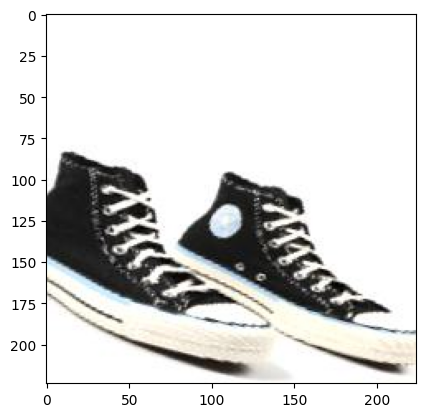

In [ ]:
plt.imshow(cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB))

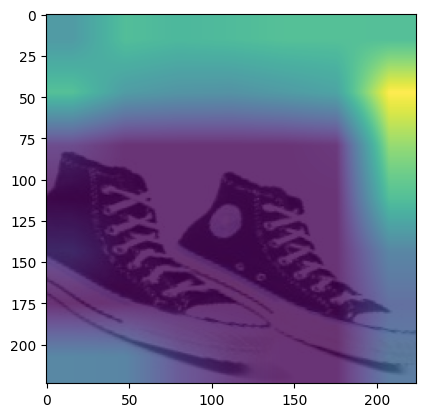

In [ ]:
#plt.imshow(cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB))
plt.imshow(cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB))
plt.imshow(gradcam, alpha=0.8)

## Creando SE-RESNET50

Para crear SE-ResNet50 partimos de definir un bloque de atencion (Squeeze & excitation)

In [ ]:
def se_block(tensor):

    x = GlobalAveragePooling2D()(tensor)
    x2 = Dense(x.shape[1]//8, activation='relu',use_bias=False)(x)
    x2 = Dense(x.shape[1], activation='sigmoid',use_bias=False)(x2)
    x2 = tf.keras.layers.Reshape((1,1,x.shape[1]), input_shape=(x.shape[1],))(x2)
    x = tf.keras.layers.multiply((x2,tensor))

    return x

Debido a que vamos a utilizar el base model como modelo para introducir los bloques de atencion a la arquitectura, definimos un modelo secuencial capturando cada una de las capas del modelo base y conociendo tanto eel nombre asignado como su posicion.

In [ ]:
for i, layer in enumerate(base_model.layers):
  print(layer.name,f'pos: {i}')

input_33 pos: 0
conv1_pad pos: 1
conv1_conv pos: 2
pool1_pad pos: 3
pool1_pool pos: 4
conv2_block1_preact_bn pos: 5
conv2_block1_preact_relu pos: 6
conv2_block1_1_conv pos: 7
conv2_block1_1_bn pos: 8
conv2_block1_1_relu pos: 9
conv2_block1_2_pad pos: 10
conv2_block1_2_conv pos: 11
conv2_block1_2_bn pos: 12
conv2_block1_2_relu pos: 13
conv2_block1_0_conv pos: 14
conv2_block1_3_conv pos: 15
conv2_block1_out pos: 16
conv2_block2_preact_bn pos: 17
conv2_block2_preact_relu pos: 18
conv2_block2_1_conv pos: 19
conv2_block2_1_bn pos: 20
conv2_block2_1_relu pos: 21
conv2_block2_2_pad pos: 22
conv2_block2_2_conv pos: 23
conv2_block2_2_bn pos: 24
conv2_block2_2_relu pos: 25
conv2_block2_3_conv pos: 26
conv2_block2_out pos: 27
conv2_block3_preact_bn pos: 28
conv2_block3_preact_relu pos: 29
conv2_block3_1_conv pos: 30
conv2_block3_1_bn pos: 31
conv2_block3_1_relu pos: 32
conv2_block3_2_pad pos: 33
conv2_block3_2_conv pos: 34
conv2_block3_2_bn pos: 35
conv2_block3_2_relu pos: 36
max_pooling2d_9 pos:

Sedefine un nuevo modelo secuencial heredando las capas y los atributos de el base_model, pero introduciendo entre capas los respectivos bloques de atencion. esta nueva arquitectura la definimos como SENET y guardamos el modelo para realizar su analisis grafico en Netron, con el fin de compara la arquitectura Original

In [ ]:
input=tf.keras.layers.Input(shape = (224, 224, 3), name = 'InputLayer')
x=base_model.layers[1](input)
for i in range(2,6):x=base_model.layers[i](x)

xs=base_model.layers[6](x)#relu

##conv block 1
x=base_model.layers[7](xs)
for i in range(8,14):x=base_model.layers[i](x)
x=base_model.layers[15](x)
x=se_block(x)
xs=base_model.layers[14](xs)
x = Add()([x, xs])

#ident block 1
xs=x
for i in range(17,27):x=base_model.layers[i](x)
x=se_block(x)
x = Add()([x, xs])

xs=x
for i in range(28,37):x=base_model.layers[i](x)
x=base_model.layers[38](x)
x=se_block(x)
xs=base_model.layers[37](xs)
x = Add()([x, xs])

##conv block 3
x=base_model.layers[40](x)
x=base_model.layers[41](x)
xs=x
for i in range(42,49):x=base_model.layers[i](x)
x=base_model.layers[50](x)
x=se_block(x)
xs=base_model.layers[49](xs)
x = Add()([x, xs])

xs=x
for i in range(52,62):x=base_model.layers[i](x)
x=se_block(x)
x = Add()([x, xs])

xs=x
for i in range(63,73):x=base_model.layers[i](x)
x=se_block(x)
x = Add()([x, xs])

xs=x
for i in range(74,83):x=base_model.layers[i](x)
x=base_model.layers[84](x)
x=se_block(x)
xs=base_model.layers[83](xs)
x = Add()([x, xs])

##conv block 4
x=base_model.layers[86](x)
x=base_model.layers[87](x)

xs=x
for i in range(88,95):x=base_model.layers[i](x)
x=base_model.layers[96](x)
x=se_block(x)
xs=base_model.layers[95](xs)
x = Add()([x, xs])

xs=x
for i in range(98,108):x=base_model.layers[i](x)
x=se_block(x)
x = Add()([x, xs])

xs=x
for i in range(109,119):x=base_model.layers[i](x)
x=se_block(x)
x = Add()([x, xs])

xs=x
for i in range(120,130):x=base_model.layers[i](x)
x=se_block(x)
x = Add()([x, xs])

xs=x
for i in range(131,141):x=base_model.layers[i](x)
x=se_block(x)
x = Add()([x, xs])

xs=x
for i in range(142,151):x=base_model.layers[i](x)
x=base_model.layers[152](x)
x=se_block(x)
xs=base_model.layers[151](xs)
x = Add()([x, xs])

## conv block 5
x=base_model.layers[154](x)
x=base_model.layers[155](x)
xs=x
for i in range(156,163):x=base_model.layers[i](x)
x=base_model.layers[164](x)
x=se_block(x)
xs=base_model.layers[163](xs)
x = Add()([x, xs])

xs=x
for i in range(166,176):x=base_model.layers[i](x)
x=se_block(x)
x = Add()([x, xs])

xs=x
for i in range(177,187):x=base_model.layers[i](x)
x=se_block(x)
x = Add()([x, xs])
last_conv_layer_model =tf.keras.Model(input, x)
x=base_model.layers[188](x)
x=base_model.layers[189](x)

output=x

SENET=tf.keras.Model(input, output)
SENET.save('Senet2.h5')

A nuestra nueva arquitectura modificada, anadimos finalmente las capas de la estapa clasificadora para poder clasificar las imagenes del dataset.
Se conserva la misma estrucutra de clasificacion del modelo definido para el entrenamiento previo sin bloques de atencion. Nuestra arquitectura final recibe el nombre de SERESNET50V2

In [ ]:
SENET.trainable = False

inputsv2 = tf.keras.layers.Input(shape = (224, 224, 3), name = 'InputLayer')
x = SENET(inputsv2)
x = tf.keras.layers.GlobalAveragePooling2D(name = 'global_average_pooling_layer')(x)
x = Flatten()(x)
x = tf.keras.layers.Dense(512, activation = 'softmax', name = 'Dense_layer')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputsv2 = tf.keras.layers.Dense(3, activation = 'softmax', name = 'output_layer')(x)

SERESNET50v2 = tf.keras.Model(inputsv2, outputsv2)

Analizamos la distribucion de capas de nuestro modelo SENET y SERESNET50V2

In [ ]:
SENET.summary()

Model: "model_53"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 InputLayer (InputLayer)        [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['InputLayer[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[1][0]']              
                                )                                                                 
                                                                                           

In [ ]:
SERESNET50v2.summary()

Model: "model_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 model_53 (Functional)       (None, 7, 7, 2048)        28594688  
                                                                 
 global_average_pooling_laye  (None, 2048)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 flatten_7 (Flatten)         (None, 2048)              0         
                                                                 
 Dense_layer (Dense)         (None, 512)               1049088   
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                          

Compilamos nuestro modelo utilizando igualmente una metrica de TopKCategoricalAccuracy

In [ ]:
from tensorflow.keras.metrics import TopKCategoricalAccuracy
SERESNET50v2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics = ['accuracy',TopKCategoricalAccuracy(k=1)]
)

In [ ]:
hist2 = SERESNET50v2.fit(training_set,
                validation_data = valid_set,
                epochs = 20,
                steps_per_epoch=len(training_set),
                validation_steps=len(valid_set))

c:\Users\AndresVJ\.conda\envs\tf\lib\site-packages\keras\preprocessing\image.py:1863: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
c:\Users\AndresVJ\.conda\envs\tf\lib\site-packages\keras\preprocessing\image.py:1873: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/20
240/240 [==============================] - 63s 239ms/step - loss: 1.0801 - accuracy: 0.4198 - top_k_categorical_accuracy: 0.4320 - val_loss: 1.0527 - val_accuracy: 0.4885 - val_top_k_categorical_accuracy: 0.0910
Epoch 2/20
240/240 [==============================] - 56s 232ms/step - loss: 1.0307 - accuracy: 0.4894 - top_k_categorical_accuracy: 0.1850 - val_loss: 1.0081 - val_accuracy: 0.5847 - val_top_k_categorical_accuracy: 0.3211
Epoch 3/20
240/240 [==============================] - 55s 231ms/step - loss: 0.9847 - accuracy: 0.5304 - top_k_categorical_accuracy: 0.2940 - val_loss: 0.9692 - val_accuracy: 0.6109 - val_top_k_categorical_accuracy: 0.4027
Epoch 4/20
240/240 [==============================] - 55s 231ms/step - loss: 0.9430 - accuracy: 0.5607 - top_k_categorical_accuracy: 0.3225 - val_loss: 0.9346 - val_accuracy: 0.6161 - val_top_k_categorical_accuracy: 0.2971
Epoch 5/20
240/240 [==============================] - 56s 232ms/step - loss: 0.9182 - accuracy: 0.5627 - top

Guardamos el Modelo y sus pesos

In [ ]:
SERESNET50v2.save('Se-Resnet50v2.h5')
SERESNET50v2.save_weights('Se-Resnet50v2_weights.h5')

In [ ]:
# Evaluate the model
loss, acc, top1_acc = SERESNET50v2.evaluate(test_set, verbose=0)

print(f'Top-1 Accuracy: {top1_acc * 100:.2f}%')

Top-1 Accuracy: 37.26%


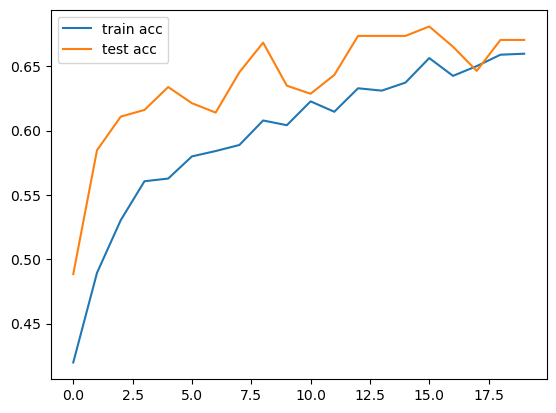

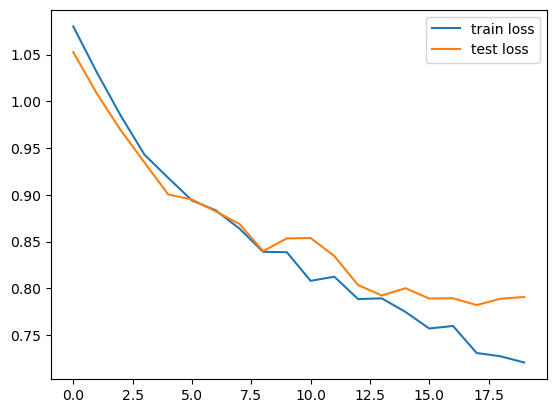

In [ ]:
plt.plot(hist2.history['accuracy'], label='train acc')

plt.plot(hist2.history['val_accuracy'], label='test acc')

plt.legend()

plt.savefig('resnet50-acc-rps-1.png')

plt.show()

# loss
plt.plot(hist2.history['loss'], label='train loss')
plt.plot(hist2.history['val_loss'], label='test loss')
plt.legend()
plt.savefig('resnet50-loss-rps-1.png')
plt.show()

In [ ]:
#predict
y_pred = SERESNET50v2.predict(test_set)
y_pred = np.argmax(y_pred,axis=1)

#get classification report
print(classification_report(y_pred,test_y))

#get confusion matrix
cm = confusion_matrix(y_pred,test_y)

print(cm)

121/121 [==============================] - 6s 35ms/step
              precision    recall  f1-score   support

           0       0.36      0.33      0.34       721
           1       0.29      0.30      0.29       605
           2       0.30      0.32      0.31       609

    accuracy                           0.32      1935
   macro avg       0.32      0.32      0.32      1935
weighted avg       0.32      0.32      0.32      1935

[[235 240 246]
 [216 184 205]
 [195 219 195]]


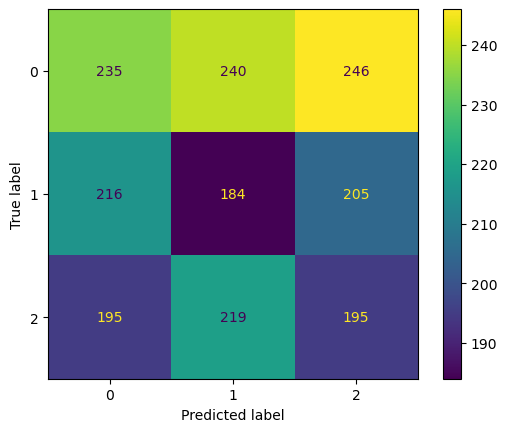

In [ ]:
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

## GRADCAM

para hacer uso del Gradcam primero cargamamos una imagen del dataset de test y verificamos su prediccion.

In [ ]:
imagen="G:/tenis/augmented2/test/converse/dr_9_6078.jpg"
img_arr=cv2.imread(imagen,cv2.IMREAD_COLOR)
img_arr=cv2.resize(img_arr,(224,224))


pred_cam = SERESNET50v2.predict(img_arr.reshape(1,224,224,3))

print(np.argmax(pred_cam[0]))

1/1 [==============================] - 1s 1s/step
2


utilizando el summary de keras definimos cual es la ultima capa convolucional del modelo, al haber realizado transfer learning de nuestro modelo SENET, y como dicho modelo no incorpora las capas de clasificacion, lo tomamos como nuestra ultima capa convolucional denominada "model_40" es importante tener en cuenta que esta capa no recibe un nombre especifico y cada vez que la ejecutemos va a cambiar su nomenclatura.

In [ ]:
last_conv_layer = SERESNET50v2.get_layer('model_53')
last_conv_layer

In [ ]:
last_conv_layer = SERESNET50v2.get_layer('model_53')

classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
x = SERESNET50v2.get_layer('global_average_pooling_layer')(x)
x = SERESNET50v2.get_layer('Dense_layer')(x)
x = SERESNET50v2.get_layer('output_layer')(x)
classifier_model = tf.keras.Model(classifier_input, x)



with tf.GradientTape() as tape:
    inputs = img_arr.reshape(1,224,224,3)
    last_conv_layer_output = last_conv_layer_model(inputs)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

last_conv_layer_output = last_conv_layer_output.numpy()[0]
pooled_grads = pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

# Average over all the filters to get a single 2D array
gradcam = np.mean(last_conv_layer_output, axis=-1)
# Clip the values (equivalent to applying ReLU)
# and then normalise the values
gradcam = np.clip(gradcam, 0, np.max(gradcam)) / np.max(gradcam)
gradcam = cv2.resize(gradcam, (224, 224))

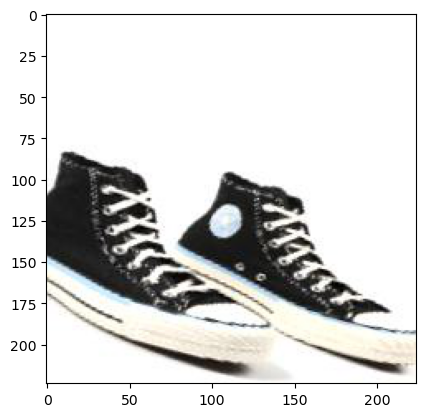

In [ ]:
plt.imshow(cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB))

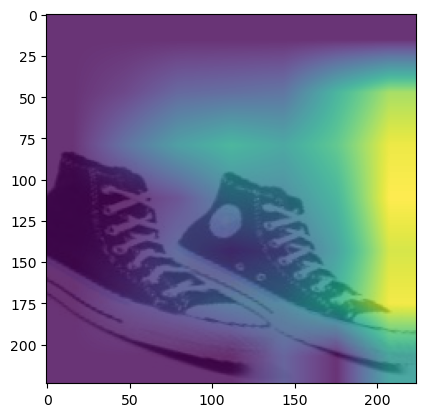

In [ ]:
#plt.imshow(cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB))
plt.imshow(cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB))
plt.imshow(gradcam, alpha=0.8)